# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.0 MB/s eta 0:00:00


In [3]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.interpolate import interp1d
from google.colab import files

## Global Definitions

In [4]:
# Path to the zip file
#data_dir = "./Data"
#data_path = f"{data_dir}/Xtrain.mat"
mat_data = files.upload()
data = loadmat('Xtrain.mat')

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Set a professional style for the plots
sns.set_theme(style="whitegrid")

Saving Xtrain.mat to Xtrain.mat


In [5]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.6.0+cu124
12.4
90300
True


### Utilities

In [25]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, attempt_index, epochs=20, lr=1e-3, teacher_forcing_prob=0.5, patience=25):
    """
    Train the given model with validation and return the final validation L1 loss.
    Includes early stopping based on validation loss.
    Logs all metrics (L1, MSE, MAE) for each epoch into a DataFrame.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    # Define loss functions
    huberLoss_criterion = nn.HuberLoss()  # Huber Loss
    mse_criterion = nn.MSELoss()  # MSE Loss
    mae_criterion = nn.L1Loss()  # MAE Loss (same as L1 Loss)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state
    no_improvement_epochs = 0  # Counter for early stopping

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_l1", "train_mse", "train_mae", "val_l1", "val_mse", "val_mae"])

    # Progress bar for epochs
    epochs_pbar = tqdm(range(epochs), desc=f"Trial: {attempt_index}", unit="epoch")

    for epoch in epochs_pbar:
        # Training phase
        model.train()
        running_train_huberLoss_loss = 0.0
        running_train_mse_loss = 0.0
        running_train_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            # Calculate loss
            huberLoss_loss = huberLoss_criterion(output, y_batch)
            mse_loss = mse_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_train_huberLoss_loss += huberLoss_loss.item()
            running_train_mse_loss += mse_loss.item()
            running_train_mae_loss += mae_loss.item()

            # Backward pass
            optimizer.zero_grad()
            mae_loss.backward()
            optimizer.step()

        avg_train_huberLoss_loss = running_train_huberLoss_loss / len(train_loader)
        avg_train_mse_loss = running_train_mse_loss / len(train_loader)
        avg_train_mae_loss = running_train_mae_loss / len(train_loader)

        # Validation phase
        model.eval()
        running_val_huberLoss_loss = 0.0
        running_val_mse_loss = 0.0
        running_val_mae_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)

                huberLoss_loss = huberLoss_criterion(output, y_batch)
                mse_loss = mse_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_val_huberLoss_loss += huberLoss_loss.item()
                running_val_mse_loss += mse_loss.item()
                running_val_mae_loss += mae_loss.item()

        avg_val_huberLoss_loss = running_val_huberLoss_loss / len(val_loader)
        avg_val_mse_loss = running_val_mse_loss / len(val_loader)
        avg_val_mae_loss = running_val_mae_loss / len(val_loader)

        # Save metrics to DataFrame
        new_row = pd.DataFrame([{
            "trial_id": attempt_index,
            "epoch": epoch + 1,
            "train_HuberLoss": avg_train_huberLoss_loss,
            "train_MSE": avg_train_mse_loss,
            "train_MAE": avg_train_mae_loss,
            "val_HuberLoss": avg_val_huberLoss_loss,
            "val_MSE": avg_val_mse_loss,
            "val_MAE": avg_val_mae_loss
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the best model
        if avg_val_mse_loss < best_val_loss:
            best_val_loss = avg_val_mse_loss
            best_model_state = model.state_dict()
            no_improvement_epochs = 0  # Reset early stopping counter
        else:
            no_improvement_epochs += 1  # Increment early stopping counter

        # Early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # Adjust learning rate
        scheduler.step()

        # Update progress bar
        epochs_pbar.set_postfix(
            Train_huberLoss_Loss=avg_train_huberLoss_loss,
            Train_MSE_Loss=avg_train_mse_loss,
            Train_MAE_Loss=avg_train_mae_loss,
            Val_huberLoss_Loss=avg_val_huberLoss_loss,
            Val_MSE_Loss=avg_val_mse_loss,
            Val_MAE_Loss=avg_val_mae_loss,
        )

    # Load the best model
    model.load_state_dict(best_model_state)

    return best_val_loss, metrics_df  # Return the best validation L1 loss and metrics DataFrame

### Long short-term memory (LSTM) RNN Model

In [23]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

'''class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout=0.0) :
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True, dropout=dropout if num_stacked_layers > 1 else 0.0)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out'''

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout=0.0) :
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.dropout = dropout

        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers,
                            batch_first=True, dropout=dropout if num_stacked_layers > 1 else 0.0, nonlinearity="tanh")

        self.fc = nn.Linear(hidden_size, 1)
        # Initialize weights based on activation
        self.apply(self.initialize_weights_xavier)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        #c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

    def initialize_weights_xavier(self, m):
        if isinstance(m, nn.RNN):
            for name, param in m.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

### Load and Split the dataset into train-validation

In [19]:
# Define augmentation functions
def add_noise(x, std=0.05):
    return x + np.random.normal(0, std, size=x.shape)

def add_drift(x, strength=0.05):
    drift = np.linspace(0, strength, num=len(x)).reshape(-1, 1)
    return x + drift

def time_warp(x, stretch_factor=1.15):
    original_steps = np.arange(len(x))
    new_steps = np.linspace(0, len(x) - 1, int(len(x) * stretch_factor))
    warped = interp1d(original_steps, x.ravel(), kind='linear', fill_value="extrapolate")(new_steps)
    warped = warped[:len(x)]  # clip/pad to original size
    return warped.reshape(-1, 1)

# Define jittering function
def add_jitter(x, std=0.01):
    """
    Add small random perturbations (jitter) to the data.

    Args:
        x (np.ndarray): Input data.
        std (float): Standard deviation of the jitter.

    Returns:
        np.ndarray: Jittered data.
    """
    return x + np.random.normal(0, std, size=x.shape)


measurements = data['Xtrain']
# Check the shape of the data
print("Shape of measurements:", measurements.shape)

# Display the first few rows of the data
print(f"First 5 measurements: {measurements[:5]}")

print(f"measurements range: min={measurements.min()}, max={measurements.max()}")

# Creating sequences
max_window_size = 50  # Maximum window size
# Split data into training and validation sets
size_of_test = 200 + max_window_size  # 200 steps for testing + window size
train_data, val_data = measurements[:-size_of_test], measurements[-size_of_test:]

# Normalize the training data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Normalize the validation data using the same scaler
val_data_normalized = scaler.transform(val_data)

# Augment training data
print(f"Train shape before augmention: {train_data.shape}")

augmented = [train_data]  # 1x original

'''for _ in range(2):  # 2x noise
    augmented.append(add_noise(train_data))

# for _ in range(2):  # 2x drift
#     augmented.append(add_drift(train_data))

# for _ in range(2):  # 2x time warp
#     augmented.append(time_warp(train_data))

for _ in range(2):  # 2x jittering
    augmented.append(add_jitter(train_data))

train_augmented = np.vstack(augmented)
print("Augmented shape:", train_augmented.shape)'''

# Creating sequences
train_dataset, val_dataset = train_data, val_data_normalized

print(f"Train shape: {train_dataset.shape}, Val shape: {val_dataset.shape}")
print(f"train_dataset range: min={train_dataset.min()}, max={train_dataset.max()}")
print(f"val_dataset range: min={val_dataset.min()}, max={val_dataset.max()}")

Shape of measurements: (1000, 1)
First 5 measurements: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
measurements range: min=2, max=255
Train shape before augmention: (750, 1)
Train shape: (750, 1), Val shape: (250, 1)
train_dataset range: min=2, max=255
val_dataset range: min=-0.9209486166007904, max=0.3992094861660078


In [20]:
# Plot the train_dataset with different colors for each augmentation type
def plot_augmented_data(train_data, augmented_data, num_augmentations):
    plt.figure(figsize=(30, 6))

    # Plot the original data
    plt.plot(train_data, label="Original Data", color="blue", linewidth=2)

    # Plot the augmented data
    start_idx = len(train_data)
    for i in range(num_augmentations):
        end_idx = start_idx + len(train_data)
        if i < 2:
            label = f"Noise Augmentation {i + 1}"
            color = "orange"
        # elif i < 4:
        #     label = f"Drift Augmentation {i - 1}"
        #     color = "green"
        # elif i < 6:
        #     label = f"Time Warp Augmentation {i - 3}"
        #     color = "red"
        else:
            label = f"Jittering Augmentation {i - 5}"
            color = "purple"
        plt.plot(range(start_idx, end_idx), augmented_data[start_idx:end_idx], label=label, color=color, linewidth=1)
        start_idx = end_idx

    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Value")
    plt.title("Augmented Training Data")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot the data
#plot_augmented_data(train_data, train_augmented, num_augmentations=4)

### Training the Model

In [26]:
best_model = None

# Initialize a global DataFrame to store metrics for all trials
all_metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_HuberLoss", "train_MSE", "train_MAE", "val_HuberLoss", "val_MSE", "val_MAE",
                                       "hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"])

def objective(trial):
    global all_metrics_df  # Use the global DataFrame to store metrics

    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 2)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    window_size = trial.suggest_int('window_size', 5, 105, step=5)
    dropout = trial.suggest_float('dropout', 0.0, 0.3, step=0.1)

    # Update data loaders with the suggested batch size
    train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
    val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)

    # Define the model
    model = RNN(
        input_size=1,  # Number of features in the input sequence
        hidden_size=hidden_size, # Number of features in the hidden state
        num_stacked_layers=num_layers, # Number of LSTM layers
        dropout=dropout  # Dropout rate
    ).to(device)

    # Train the model and get the final validation loss and metrics DataFrame
    trial_index = trial.number + 1  # Start from 1 for better readability in logs
    val_loss, metrics_df = train_model(
        model, train_loader, val_loader, attempt_index=trial_index, epochs=100, lr=learning_rate
    )

    # Add trial parameters to the metrics DataFrame
    metrics_df["hidden_size"] = hidden_size
    metrics_df["num_layers"] = num_layers
    metrics_df["learning_rate"] = learning_rate
    metrics_df["batch_size"] = batch_size
    metrics_df["window_size"] = window_size
    metrics_df["dropout"] = dropout  # Log the dropout value


    # Save the best model
    if trial.number == 0 or val_loss < study.best_value:
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved with trial {trial.number}")
        best_model = model

        # Save the best hyperparameters
        with open("best_hyperparameters.json", "w") as f:
            json.dump({
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "window_size": window_size,
                "dropout": dropout
            }, f)

    # Append the metrics for this trial to the global DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    return val_loss  # Optuna will minimize this


# Create a study object
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Optimize the objective function
study.optimize(objective, n_trials=100)  # Run 100 trials

# Save the combined metrics DataFrame to a CSV file
all_metrics_df.to_csv("all_trials_metrics.csv", index=False)
print("All metrics saved to all_trials_metrics.csv")

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Print the best validation loss
print("Best validation loss:", study.best_value)

# Load the best model
best_model = RNN(
    input_size=1,
    hidden_size=study.best_params['hidden_size'],
    num_stacked_layers=study.best_params['num_layers']
).to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
print("Best model loaded.")

# Update train_loader and val_loader with the best hyperparameters
train_loader, train_X, train_y = prepare_dataloader(train_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
val_loader, val_X, val_y = prepare_dataloader(val_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
print("Data loaders updated with best hyperparameters.")

[I 2025-05-07 12:32:24,523] A new study created in memory with name: no-name-0170c8fb-7962-4656-a71c-10da2f3c3950


Trial: 1:   0%|          | 0/100 [00:00<?, ?epoch/s]

<ipython-input-26-a2f0851c2a70>:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
[I 2025-05-07 12:32:34,100] Trial 0 finished with value: 2.0653092520577565 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0018980983838403, 'batch_size': 32, 'window_size': 50, 'dropout': 0.3}. Best is trial 0 with value: 2.0653092520577565.


Early stopping triggered after 48 epochs.
Best model saved with trial 0


Trial: 2:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:32:38,318] Trial 1 finished with value: 0.5590179622173309 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.00031198696323776455, 'batch_size': 32, 'window_size': 95, 'dropout': 0.0}. Best is trial 1 with value: 0.5590179622173309.


Early stopping triggered after 26 epochs.
Best model saved with trial 1


Trial: 3:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:32:41,106] Trial 2 finished with value: 0.39992854992548627 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0002772289612731585, 'batch_size': 64, 'window_size': 105, 'dropout': 0.0}. Best is trial 2 with value: 0.39992854992548627.


Early stopping triggered after 27 epochs.
Best model saved with trial 2


Trial: 4:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:32:45,921] Trial 3 finished with value: 0.5436069704592228 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.00032176811257335244, 'batch_size': 32, 'window_size': 15, 'dropout': 0.0}. Best is trial 2 with value: 0.39992854992548627.


Early stopping triggered after 26 epochs.


Trial: 5:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:32:51,299] Trial 4 finished with value: 21.419235110282898 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.004879885088682422, 'batch_size': 32, 'window_size': 15, 'dropout': 0.2}. Best is trial 2 with value: 0.39992854992548627.


Early stopping triggered after 33 epochs.


Trial: 6:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:32:55,828] Trial 5 finished with value: 0.2537601888179779 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 8.785182865645043e-05, 'batch_size': 64, 'window_size': 5, 'dropout': 0.3}. Best is trial 5 with value: 0.2537601888179779.


Early stopping triggered after 47 epochs.
Best model saved with trial 5


Trial: 7:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:33:02,976] Trial 6 finished with value: 7.903731505076091 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.001987082654746345, 'batch_size': 32, 'window_size': 65, 'dropout': 0.3}. Best is trial 5 with value: 0.2537601888179779.


Early stopping triggered after 41 epochs.


Trial: 8:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:33:05,588] Trial 7 finished with value: 0.21890147030353546 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 4.867914200934593e-05, 'batch_size': 64, 'window_size': 5, 'dropout': 0.0}. Best is trial 7 with value: 0.21890147030353546.


Early stopping triggered after 27 epochs.
Best model saved with trial 7


Trial: 9:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:33:11,391] Trial 8 finished with value: 0.13685433566570282 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 1.758742237848906e-05, 'batch_size': 32, 'window_size': 20, 'dropout': 0.0}. Best is trial 8 with value: 0.13685433566570282.


Early stopping triggered after 28 epochs.
Best model saved with trial 8


Trial: 10:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:33:14,233] Trial 9 finished with value: 0.7411974519491196 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.001014481457960527, 'batch_size': 64, 'window_size': 55, 'dropout': 0.0}. Best is trial 8 with value: 0.13685433566570282.


Early stopping triggered after 26 epochs.


Trial: 11:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:33:21,483] Trial 10 finished with value: 0.10416205333811897 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.0846059788637568e-05, 'batch_size': 32, 'window_size': 35, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 40 epochs.
Best model saved with trial 10


Trial: 12:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:33:32,433] Trial 11 finished with value: 0.2511025624615805 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.1317871729886698e-05, 'batch_size': 32, 'window_size': 35, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 62 epochs.


Trial: 13:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:33:39,786] Trial 12 finished with value: 0.22022860922983714 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.127650537094765e-05, 'batch_size': 32, 'window_size': 35, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 43 epochs.


Trial: 14:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:33:57,023] Trial 13 finished with value: 0.2085959357874734 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lr': 3.434870702721851e-05, 'batch_size': 32, 'window_size': 35, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Trial: 15:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:34:03,822] Trial 14 finished with value: 0.2157295768459638 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 2.980385704620903e-05, 'batch_size': 32, 'window_size': 75, 'dropout': 0.2}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 41 epochs.


Trial: 16:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:34:08,588] Trial 15 finished with value: 0.19630223722197115 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 9.979152470553459e-05, 'batch_size': 32, 'window_size': 25, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 17:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:34:14,029] Trial 16 finished with value: 0.1619586263384138 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 1.8767096700113637e-05, 'batch_size': 32, 'window_size': 45, 'dropout': 0.2}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 28 epochs.


Trial: 18:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:34:22,316] Trial 17 finished with value: 0.1898475051857531 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 9.287128527446811e-05, 'batch_size': 32, 'window_size': 25, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 48 epochs.


Trial: 19:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:34:26,633] Trial 18 finished with value: 0.3901924391587575 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 2.026593740789873e-05, 'batch_size': 64, 'window_size': 75, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 42 epochs.


Trial: 20:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:34:34,866] Trial 19 finished with value: 0.18027879390865564 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 5.014227823456857e-05, 'batch_size': 32, 'window_size': 20, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 47 epochs.


Trial: 21:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:34:40,366] Trial 20 finished with value: 0.23820722103118896 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 1.0440510320014648e-05, 'batch_size': 32, 'window_size': 40, 'dropout': 0.2}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 30 epochs.


Trial: 22:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:34:47,342] Trial 21 finished with value: 0.2653949814183371 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 1.9994990952640538e-05, 'batch_size': 32, 'window_size': 45, 'dropout': 0.2}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 32 epochs.


Trial: 23:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:34:55,174] Trial 22 finished with value: 0.394274244705836 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 1.89844272696983e-05, 'batch_size': 32, 'window_size': 60, 'dropout': 0.2}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 42 epochs.


Trial: 24:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:35:00,320] Trial 23 finished with value: 0.27807231886046274 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 5.557508937883236e-05, 'batch_size': 32, 'window_size': 30, 'dropout': 0.2}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 25:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:35:05,025] Trial 24 finished with value: 0.5041500372546059 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00017480951976012613, 'batch_size': 32, 'window_size': 45, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 26:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:35:10,739] Trial 25 finished with value: 0.24713210264841715 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 1.9592415657692918e-05, 'batch_size': 32, 'window_size': 70, 'dropout': 0.2}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 28 epochs.


Trial: 27:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:35:18,994] Trial 26 finished with value: 0.244735985994339 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 3.037444665178659e-05, 'batch_size': 64, 'window_size': 15, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 92 epochs.


Trial: 28:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:35:29,853] Trial 27 finished with value: 0.20394362083503179 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 1.0020625091585092e-05, 'batch_size': 32, 'window_size': 50, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 60 epochs.


Trial: 29:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:35:34,540] Trial 28 finished with value: 0.24491055868566036 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0001733896000771449, 'batch_size': 32, 'window_size': 25, 'dropout': 0.3}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 30:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:35:51,011] Trial 29 finished with value: 1.1488707576479231 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0006901363150592183, 'batch_size': 32, 'window_size': 50, 'dropout': 0.3}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 87 epochs.


Trial: 31:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:35:55,662] Trial 30 finished with value: 1077.1626150948662 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.008299470208181992, 'batch_size': 32, 'window_size': 40, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 32:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:36:03,476] Trial 31 finished with value: 0.233979482203722 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 5.271913572711407e-05, 'batch_size': 32, 'window_size': 20, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 44 epochs.


Trial: 33:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:36:19,291] Trial 32 finished with value: 0.25287563540041447 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 1.5739155517849354e-05, 'batch_size': 32, 'window_size': 10, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 85 epochs.


Trial: 34:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:36:33,571] Trial 33 finished with value: 0.19159105632986342 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 3.208605708627478e-05, 'batch_size': 32, 'window_size': 30, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 85 epochs.


Trial: 35:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:36:42,178] Trial 34 finished with value: 0.14498636405915022 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 4.222651367518793e-05, 'batch_size': 32, 'window_size': 20, 'dropout': 0.2}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 49 epochs.


Trial: 36:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:36:53,604] Trial 35 finished with value: 0.19995335768908262 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 1.6622478668632022e-05, 'batch_size': 32, 'window_size': 20, 'dropout': 0.2}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 67 epochs.


Trial: 37:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:00,031] Trial 36 finished with value: 0.3127190073331197 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 2.7192206213950165e-05, 'batch_size': 64, 'window_size': 85, 'dropout': 0.2}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 67 epochs.


Trial: 38:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:05,219] Trial 37 finished with value: 0.27503573298454287 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 6.967174507186165e-05, 'batch_size': 32, 'window_size': 105, 'dropout': 0.2}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 30 epochs.


Trial: 39:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:09,770] Trial 38 finished with value: 0.22635440342128277 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.00013947771009183952, 'batch_size': 32, 'window_size': 10, 'dropout': 0.3}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 27 epochs.


Trial: 40:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:13,064] Trial 39 finished with value: 0.17604988813400269 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.00030892998274626056, 'batch_size': 64, 'window_size': 30, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 41:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:17,461] Trial 40 finished with value: 0.23175802268087864 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.0005048292191440686, 'batch_size': 32, 'window_size': 10, 'dropout': 0.2}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 42:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:21,606] Trial 41 finished with value: 0.41263405606150627 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.00025220075000008624, 'batch_size': 64, 'window_size': 30, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 43 epochs.


Trial: 43:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:31,883] Trial 42 finished with value: 0.8164873123168945 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 1.4196285653784595e-05, 'batch_size': 64, 'window_size': 40, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Trial: 44:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:34,847] Trial 43 finished with value: 0.13788967579603195 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 4.020766916951198e-05, 'batch_size': 64, 'window_size': 30, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 28 epochs.


Trial: 45:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:38,479] Trial 44 finished with value: 0.1326298601925373 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 2.472115175470957e-05, 'batch_size': 64, 'window_size': 55, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 29 epochs.


Trial: 46:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:41,303] Trial 45 finished with value: 0.18362565338611603 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 3.64453139553538e-05, 'batch_size': 64, 'window_size': 60, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 30 epochs.


Trial: 47:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:44,548] Trial 46 finished with value: 0.3189382453759511 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 4.108494945003719e-05, 'batch_size': 64, 'window_size': 90, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 30 epochs.


Trial: 48:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:49,187] Trial 47 finished with value: 0.20163721963763237 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 2.6760880970589804e-05, 'batch_size': 64, 'window_size': 5, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 42 epochs.


Trial: 49:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:51,737] Trial 48 finished with value: 0.38991527259349823 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.0015408096894960158, 'batch_size': 64, 'window_size': 15, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 50:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:37:55,444] Trial 49 finished with value: 0.2506095990538597 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 6.822861306756329e-05, 'batch_size': 64, 'window_size': 55, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 40 epochs.


Trial: 51:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:38:05,121] Trial 50 finished with value: 0.13676040433347225 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 1.3628096348917775e-05, 'batch_size': 64, 'window_size': 35, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Trial: 52:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:38:14,739] Trial 51 finished with value: 0.3213004283607006 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 1.4454122391474147e-05, 'batch_size': 64, 'window_size': 35, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Trial: 53:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:38:23,705] Trial 52 finished with value: 0.18626178801059723 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 2.3236510232820847e-05, 'batch_size': 64, 'window_size': 25, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Trial: 54:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:38:33,429] Trial 53 finished with value: 0.20023640990257263 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 1.32805955369189e-05, 'batch_size': 64, 'window_size': 20, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Trial: 55:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:38:37,913] Trial 54 finished with value: 0.18040264211595058 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 4.4035822970565516e-05, 'batch_size': 64, 'window_size': 35, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 44 epochs.


Trial: 56:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:38:47,185] Trial 55 finished with value: 0.2972196564078331 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 2.3803332306457686e-05, 'batch_size': 64, 'window_size': 25, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Trial: 57:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:38:56,894] Trial 56 finished with value: 0.49219758808612823 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 1.2619352294182656e-05, 'batch_size': 64, 'window_size': 40, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Trial: 58:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:38:59,478] Trial 57 finished with value: 0.1410209909081459 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.00011559393966298086, 'batch_size': 64, 'window_size': 15, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 59:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:02,584] Trial 58 finished with value: 0.10725730750709772 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 6.972846773473257e-05, 'batch_size': 64, 'window_size': 15, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 60:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:07,672] Trial 59 finished with value: 0.2444791179150343 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 1.0449936320771326e-05, 'batch_size': 64, 'window_size': 5, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 48 epochs.


Trial: 61:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:11,134] Trial 60 finished with value: 0.22713752463459969 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 6.392637280295054e-05, 'batch_size': 64, 'window_size': 45, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 31 epochs.


Trial: 62:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:14,046] Trial 61 finished with value: 0.19855034537613392 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.00012543966204041907, 'batch_size': 64, 'window_size': 15, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 27 epochs.


Trial: 63:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:17,391] Trial 62 finished with value: 0.11111618299037218 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 7.945008640416879e-05, 'batch_size': 64, 'window_size': 10, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 28 epochs.


Trial: 64:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:20,200] Trial 63 finished with value: 0.19674580357968807 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 8.142855946796528e-05, 'batch_size': 64, 'window_size': 10, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 65:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:23,460] Trial 64 finished with value: 0.2931688390672207 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 2.3647175288771463e-05, 'batch_size': 64, 'window_size': 35, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 30 epochs.


Trial: 66:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:26,345] Trial 65 finished with value: 0.1974617037922144 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 3.4545126369839305e-05, 'batch_size': 64, 'window_size': 25, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 27 epochs.


Trial: 67:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:31,393] Trial 66 finished with value: 0.16780591756105423 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 1.7861393947627795e-05, 'batch_size': 64, 'window_size': 30, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 44 epochs.


Trial: 68:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:34,474] Trial 67 finished with value: 0.29589884728193283 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 5.6853458943289316e-05, 'batch_size': 64, 'window_size': 55, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 28 epochs.


Trial: 69:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:37,398] Trial 68 finished with value: 0.21971416845917702 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 8.627697111712556e-05, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 27 epochs.


Trial: 70:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:44,081] Trial 69 finished with value: 0.20347556471824646 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 2.082005193789613e-05, 'batch_size': 64, 'window_size': 65, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 64 epochs.


Trial: 71:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:49,313] Trial 70 finished with value: 1.7831361293792725 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0031743949418687094, 'batch_size': 64, 'window_size': 50, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 52 epochs.


Trial: 72:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:52,564] Trial 71 finished with value: 0.14482298865914345 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.00011209706316719761, 'batch_size': 64, 'window_size': 10, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 73:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:55,122] Trial 72 finished with value: 0.1539705228060484 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.00017738153817443373, 'batch_size': 64, 'window_size': 15, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 74:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:39:57,743] Trial 73 finished with value: 0.39088037610054016 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.00020780552070515473, 'batch_size': 64, 'window_size': 15, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 75:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:40:00,416] Trial 74 finished with value: 0.18596003390848637 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.00010227361930978904, 'batch_size': 64, 'window_size': 5, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 27 epochs.


Trial: 76:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:40:03,390] Trial 75 finished with value: 0.5606646239757538 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.00045756010030503715, 'batch_size': 64, 'window_size': 30, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 26 epochs.


Trial: 77:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:40:06,869] Trial 76 finished with value: 0.2430502399802208 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 2.9726999861334705e-05, 'batch_size': 64, 'window_size': 15, 'dropout': 0.1}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 27 epochs.


Trial: 78:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:40:16,416] Trial 77 finished with value: 0.21179825766012073 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 1.1935320601908269e-05, 'batch_size': 32, 'window_size': 25, 'dropout': 0.0}. Best is trial 10 with value: 0.10416205333811897.


Early stopping triggered after 52 epochs.


Trial: 79:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:40:21,535] Trial 78 finished with value: 0.09096448682248592 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 3.754286768312357e-05, 'batch_size': 64, 'window_size': 40, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 48 epochs.
Best model saved with trial 78


Trial: 80:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:40:26,185] Trial 79 finished with value: 0.3070819356611797 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 3.79052076038083e-05, 'batch_size': 32, 'window_size': 45, 'dropout': 0.0}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 26 epochs.


Trial: 81:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:40:33,607] Trial 80 finished with value: 0.372069388628006 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 1.5709881596950076e-05, 'batch_size': 64, 'window_size': 40, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 62 epochs.


Trial: 82:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:40:37,771] Trial 81 finished with value: 0.29237861558794975 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 5.100173289759917e-05, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 42 epochs.


Trial: 83:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:40:42,652] Trial 82 finished with value: 0.20398931205272675 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 4.697702853870913e-05, 'batch_size': 64, 'window_size': 35, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 42 epochs.


Trial: 84:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:40:45,368] Trial 83 finished with value: 0.16421904042363167 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 8.036787886564517e-05, 'batch_size': 64, 'window_size': 30, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 27 epochs.


Trial: 85:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:40:49,330] Trial 84 finished with value: 0.19696763157844543 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 2.6496279882338326e-05, 'batch_size': 64, 'window_size': 50, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 43 epochs.


Trial: 86:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:40:58,060] Trial 85 finished with value: 0.4277513138949871 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 1.7933722490737606e-05, 'batch_size': 64, 'window_size': 40, 'dropout': 0.0}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 82 epochs.


Trial: 87:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:41:02,743] Trial 86 finished with value: 0.4590842979294913 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0001388066956172243, 'batch_size': 32, 'window_size': 45, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 26 epochs.


Trial: 88:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:41:05,771] Trial 87 finished with value: 0.1528216451406479 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 3.547277667052894e-05, 'batch_size': 64, 'window_size': 60, 'dropout': 0.0}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 27 epochs.


Trial: 89:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:41:10,808] Trial 88 finished with value: 0.28586435690522194 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 7.087788573279819e-05, 'batch_size': 32, 'window_size': 25, 'dropout': 0.0}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 27 epochs.


Trial: 90:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:41:13,782] Trial 89 finished with value: 0.24392061308026314 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 6.055759319382876e-05, 'batch_size': 64, 'window_size': 10, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 27 epochs.


Trial: 91:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:41:18,585] Trial 90 finished with value: 0.15667870454490185 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 2.259974522412639e-05, 'batch_size': 64, 'window_size': 15, 'dropout': 0.0}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 42 epochs.


Trial: 92:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:41:21,473] Trial 91 finished with value: 0.31537100672721863 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.00011093085017252088, 'batch_size': 64, 'window_size': 10, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 28 epochs.


Trial: 93:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:41:24,174] Trial 92 finished with value: 0.2194018866866827 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 9.525729273417834e-05, 'batch_size': 64, 'window_size': 5, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 27 epochs.


Trial: 94:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:41:28,128] Trial 93 finished with value: 0.36167924851179123 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 4.391625065155182e-05, 'batch_size': 64, 'window_size': 20, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 40 epochs.


Trial: 95:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:41:33,345] Trial 94 finished with value: 0.11378326080739498 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 1.2251553221616478e-05, 'batch_size': 64, 'window_size': 10, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 44 epochs.


Trial: 96:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:41:38,235] Trial 95 finished with value: 0.6716011563936869 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 1.1775298931313593e-05, 'batch_size': 64, 'window_size': 75, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 44 epochs.


Trial: 97:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:41:47,965] Trial 96 finished with value: 0.2311432445421815 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 1.3629763922850633e-05, 'batch_size': 32, 'window_size': 10, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 53 epochs.


Trial: 98:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:41:52,987] Trial 97 finished with value: 0.3361429385840893 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 1.5898723048162043e-05, 'batch_size': 64, 'window_size': 30, 'dropout': 0.0}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 46 epochs.


Trial: 99:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:41:59,029] Trial 98 finished with value: 0.17039448954164982 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 1.015652143256112e-05, 'batch_size': 64, 'window_size': 35, 'dropout': 0.2}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 48 epochs.


Trial: 100:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 12:42:04,367] Trial 99 finished with value: 0.25782955437898636 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 3.096587388851775e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.1}. Best is trial 78 with value: 0.09096448682248592.


Early stopping triggered after 31 epochs.
All metrics saved to all_trials_metrics.csv
Best hyperparameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 3.754286768312357e-05, 'batch_size': 64, 'window_size': 40, 'dropout': 0.1}
Best validation loss: 0.09096448682248592
Best model loaded.
Data loaders updated with best hyperparameters.


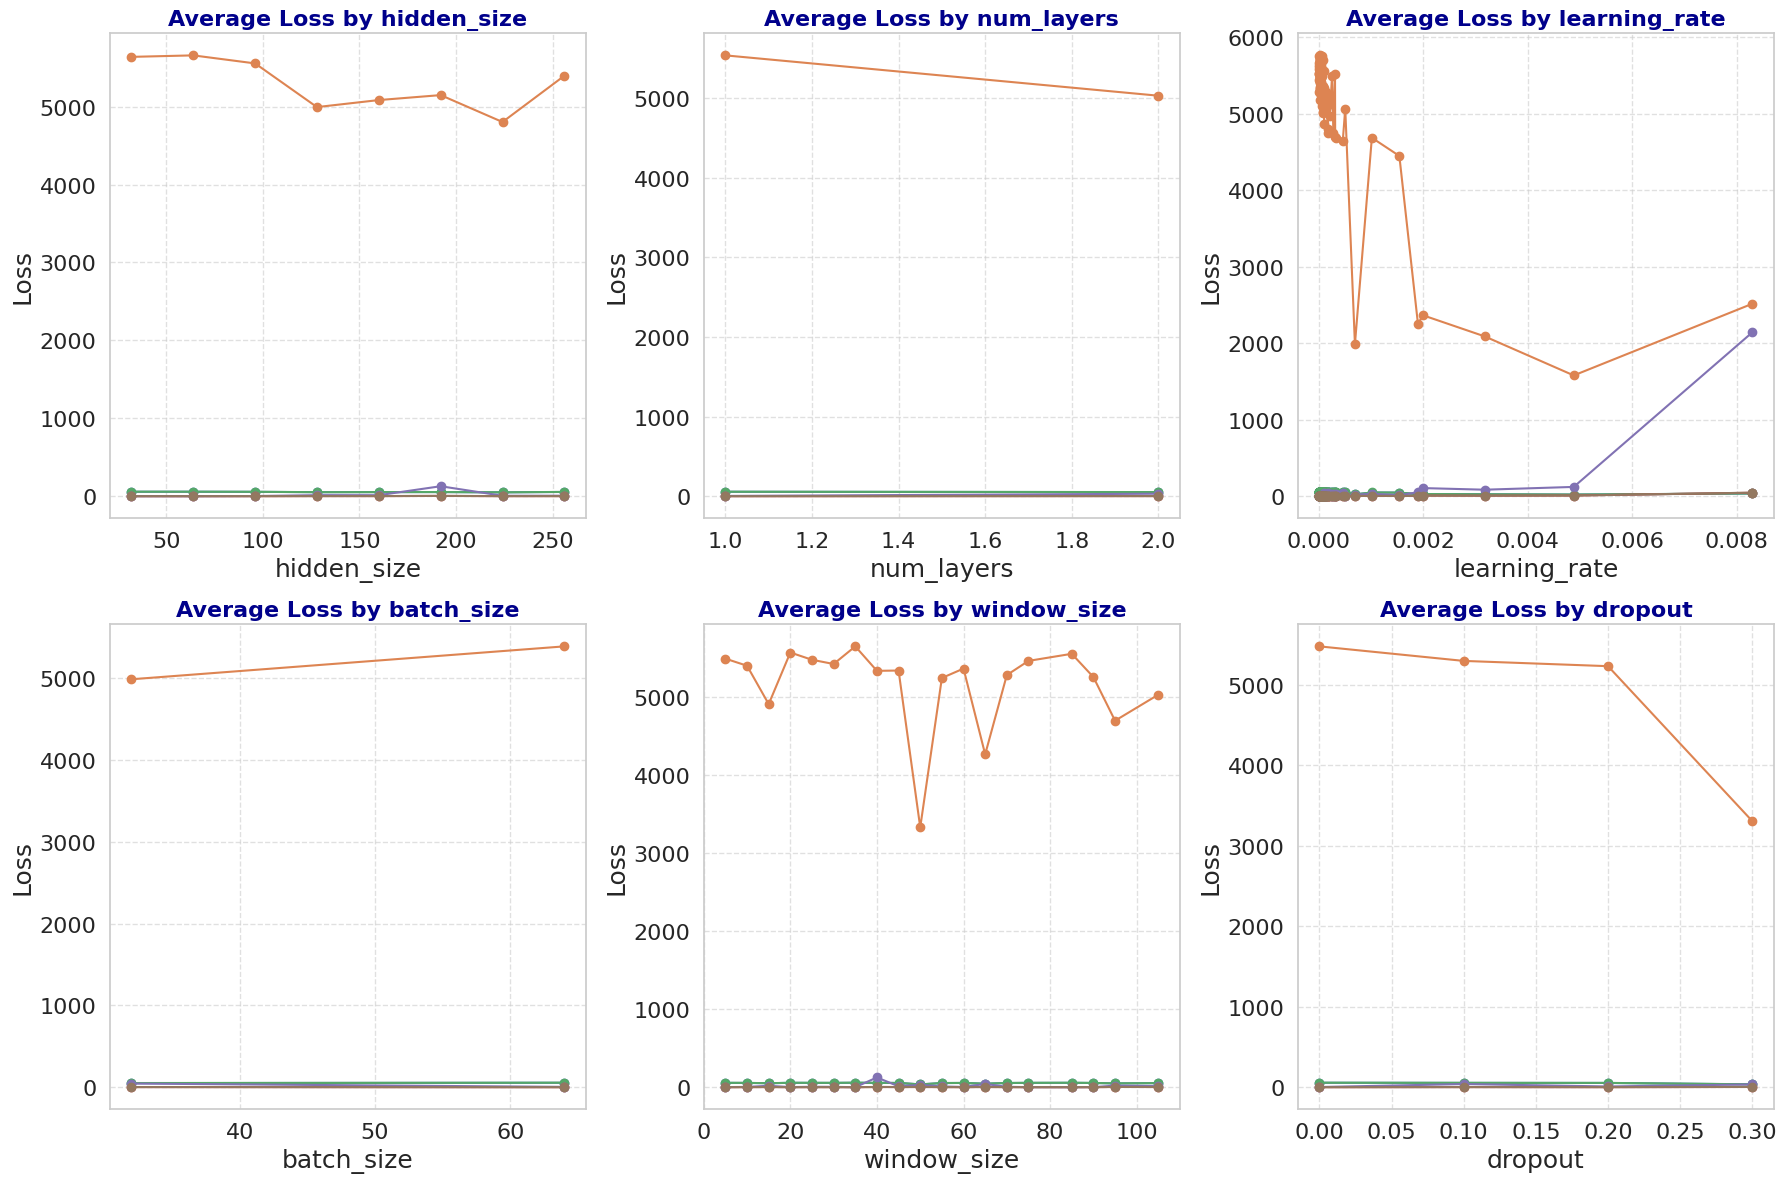

In [27]:
def plot_metrics_by_parameters(metrics_df, parameters, save_path="metrics_by_parameters.png"):
    """
    Create a single figure with subplots for each parameter, showing average losses.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        parameters (list): List of parameters to plot (e.g., ['hidden_size', 'num_layers', 'dropout']).
    """
    # Mapping loss types to more readable names
    loss_type_mapping = {
        "train_HuberLoss": "Train Huber Loss",
        "train_MSE": "Train MSE",
        "train_MAE": "Train MAE",
        "val_HuberLoss": "Validation Huber Loss",
        "val_MSE": "Validation MSE",
        "val_MAE": "Validation MAE"
    }

    num_params = len(parameters)
    ncols = 3  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        grouped = metrics_df.groupby(parameter).mean()  # Group by the parameter and calculate averages
        for loss, readable_name in loss_type_mapping.items():
            if loss in grouped.columns:
                ax.plot(grouped.index, grouped[loss], label=readable_name, marker='o', linestyle='-', linewidth=1.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(f"Average Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        if j == len(parameters):  # Use the first unused subplot for the legend
            handles, labels = ax.get_legend_handles_labels()
            axes[j].legend(
                handles, labels, loc="center", fontsize=16, title="Loss Type", title_fontsize=20, frameon=False
            )
            axes[j].set_axis_off()  # Turn off the axis for the legend plot
        else:
            fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example: Plot average losses for all parameters in one figure
parameters_to_plot = ["hidden_size", "num_layers", "learning_rate", "batch_size", "window_size", "dropout"]
plot_metrics_by_parameters(all_metrics_df, parameters_to_plot)

### Predict the next 200 data points recursively

<ipython-input-28-4be57a3fce7e>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)


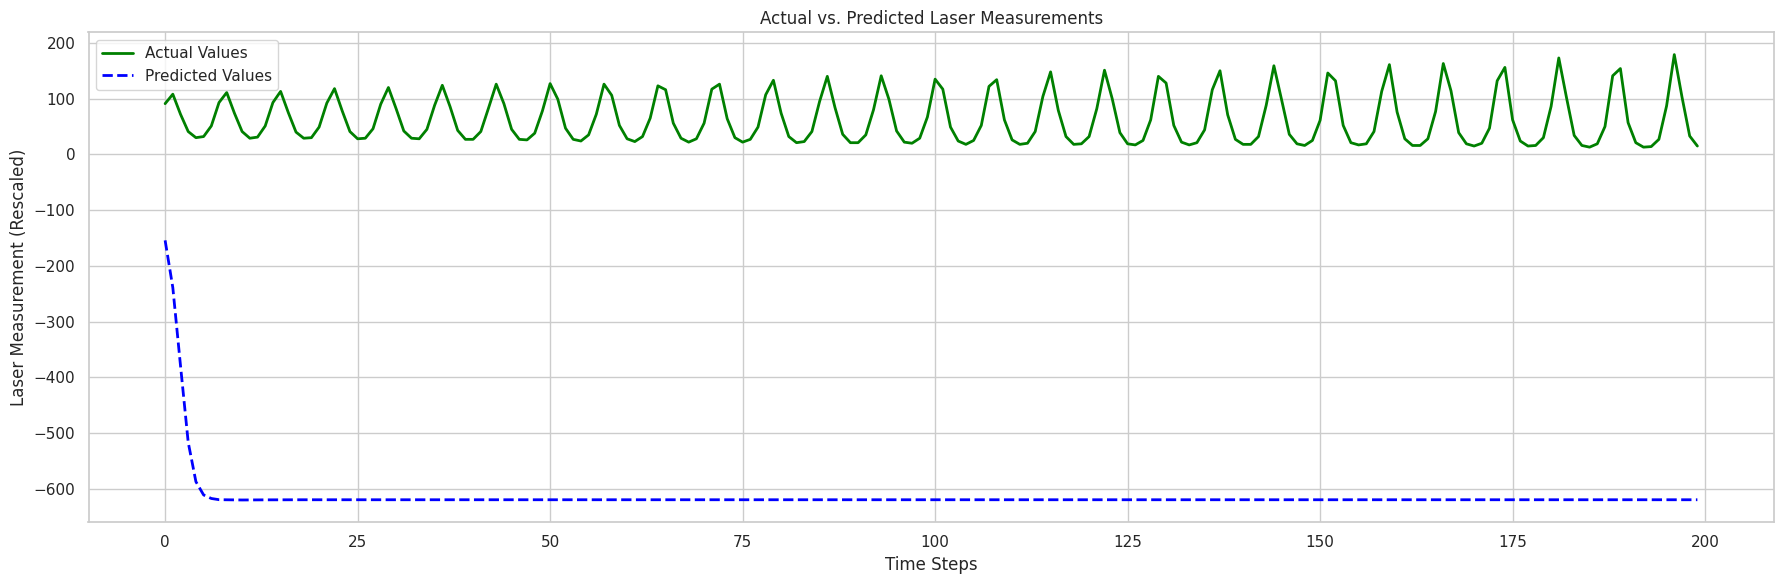

Metrics plot saved to actual_vs_predicted_plot.png


In [28]:
def predict_and_inverse_transform(model, init_window, scaler, steps=200):
    """
    Perform recursive forecasting using the trained model and convert predictions back to the original range.

    Args:
        model: The trained LSTM model.
        init_window: The initial sequence window (tensor) in normalized form.
        scaler: The MinMaxScaler used for normalization.
        steps: Number of forecasting steps.

    Returns:
        np.array: Forecasted values in the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            preds.append(pred_value)

            # Update the sequence by appending the prediction and removing the oldest value
            next_value = torch.tensor([[pred_value]], dtype=torch.float32, device=device)
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)

    # Convert predictions to numpy array
    preds = np.array(preds).reshape(-1, 1)

    # Inverse transform the predictions to the original range
    preds_original = scaler.inverse_transform(preds)

    return preds_original

def plot_signals(predictions_rescaled, actual_values, save_path="actual_vs_predicted_plot.png"):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Plot Actual vs Predicted Values
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title("Actual vs. Predicted Laser Measurements")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")

# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)

# Predict and convert back to the original range
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=200)

# Compare with the actual values (also inverse transformed if needed)
actual_signal = scaler.inverse_transform(val_y[:len(predicted_signal)])

plot_signals(predicted_signal, actual_signal)

In [29]:
import torch.nn as nn

def evaluate_model_on_validation(best_model, val_loader):
    """
    Evaluate the best model on the validation dataset and calculate MSE and MAE using PyTorch loss functions.

    Args:
        best_model: The trained model.
        val_loader: The validation dataset (normalized).

    Returns:
        mse: Mean Squared Error.
        mae: Mean Absolute Error.
    """
    # Switch the model to evaluation mode
    best_model.eval()

    # Define PyTorch loss functions
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    # Collect predictions and ground truth
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = best_model(x_batch)

            # Calculate losses
            mse = mse_criterion(output, y_batch).item()
            mae = mae_criterion(output, y_batch).item()

            # Accumulate losses
            total_mse += mse * x_batch.size(0)
            total_mae += mae * x_batch.size(0)
            num_samples += x_batch.size(0)

    # Calculate average losses
    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    print(f"Validation MSE: {avg_mse}")
    print(f"Validation MAE: {avg_mae}")

    return avg_mse, avg_mae

# Evaluate the best model
mse, mae = evaluate_model_on_validation(best_model, val_loader)

Validation MSE: 2.4198598748161677
Validation MAE: 1.5141364494959513


### Load the trained model

In [17]:
import json

def load_best_model():
    # Load the best hyperparameters
    with open("best_hyperparameters.json", "r") as f:
        best_params = json.load(f)

    # Recreate the model with the best hyperparameters
    best_model = RNN(
        input_size=1,
        hidden_size=best_params["hidden_size"],
        num_stacked_layers=best_params["num_layers"]
    ).to(device)

    # Load the saved model weights
    best_model.load_state_dict(torch.load("best_model.pth"))
    best_model.eval()

    return best_model, best_params

best_model, best_params = load_best_model()
print("Best hyperparameters are:", best_params)

Best hyperparameters are: {'hidden_size': 192, 'num_layers': 1, 'learning_rate': 6.407238474314567e-05, 'batch_size': 32, 'window_size': 15, 'dropout': 0.3}
